<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-metadata" data-toc-modified-id="Load-metadata-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load metadata</a></span></li><li><span><a href="#RNN-architecture" data-toc-modified-id="RNN-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>RNN architecture</a></span></li><li><span><a href="#Sample-a-claim" data-toc-modified-id="Sample-a-claim-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sample a claim</a></span></li><li><span><a href="#Training-procedure" data-toc-modified-id="Training-procedure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training procedure</a></span></li><li><span><a href="#RNN-Definition" data-toc-modified-id="RNN-Definition-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>RNN Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plotting-Accuracies" data-toc-modified-id="Plotting-Accuracies-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting Accuracies</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Discussion</a></span></li></ul></div>

# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [1]:
import json
import numpy as np

# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

# RNN architecture

We define a simple RNN that processes one token at time to update a hidden vector.  The last hidden vector is passed to a classifier that uses a softmax to predict the category.

In [5]:
import torch
import torch.nn as nn
import numpy as np
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

In [14]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles.nosync/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

[nltk_data] Downloading package punkt to /Users/shivam/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A line from George Orwell's novel 1984 predicts the power of smartphones.
Relevant sentences of claim 0:
['

# Sample a claim
Sample a claim, tokenize it and embed it.

In [15]:
from bpemb import BPEmb
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

def sampleClaimAndClaimant(metadata):
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    claimant = metadata[id]["claimant"]
    claim = claim + " " + claimant
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

def sampleClaimClaimantAndRelated(metadata):
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    claimant = metadata[id]["claimant"]
    claim = claim + " " + claimant
    relevant = relevant_sentences[id]
    relevant = " ".join(relevant)
    claim = claim + ' ' + relevant
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

# Training procedure


In [16]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn(line_tensor[i], hidden)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

# RNN Definition

In [17]:
import time
import math

def train_rnn(sampleClaim):
    n_hidden = 128
    n_categories = 3
    rnn = RNN(n_embedding_dims, n_hidden)
    classifier = Classifier(n_hidden, n_categories)

    criterion = nn.NLLLoss()
    learning_rate = 1e-4
    rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

    n_iters = 100000
    plot_every = 1000

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    train_data = metadata[:10000]
    test_data = metadata[10000:]
    train_cumulative_loss = 0
    test_cumulative_loss = 0
    average_train_accuracy = 0
    average_test_accuracy = 0
    all_train_losses = []
    all_train_accuracies = []
    all_test_losses = []
    all_test_accuracies = []
    count = 0
    for iter in range(1, n_iters + 1):
        train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
        train_output, train_loss = train(train_category_tensor, train_line_tensor)    
        top_train_value, top_train_index = train_output.topk(1)
        train_guess_category = top_train_index[0].item()
        train_cumulative_loss += train_loss
        train_accuracy = 1 if train_guess_category == train_category else 0
        average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)

        test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
        test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
        top_test_value, top_test_index = test_output.topk(1)
        test_guess_category = top_test_index[0].item()
        test_cumulative_loss += test_loss
        test_accuracy = 1 if test_guess_category == test_category else 0
        average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
        count += 1

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
            print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
            test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
            print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
            all_train_losses.append(train_cumulative_loss / plot_every)
            all_train_accuracies.append(average_train_accuracy)
            all_test_losses.append(test_cumulative_loss / plot_every)
            all_test_accuracies.append(average_test_accuracy)
            train_cumulative_loss = 0
            average_train_accuracy = 0
            test_cumulative_loss = 0
            average_test_accuracy = 0
            count = 0
            
    return all_test_accuracies, all_train_accuracies

# Training

In [18]:
rnn_i_test_acc, rnn_i_train_acc = train_rnn(sampleClaim)

Train: 1000  1% (0m 5s) average_accuracy=0.5590 average_loss=0.9287 In Rhode Island, "Nearly 9 percent of covered employees go out on short term disability every year, with an average outage from work of almost 12 weeks each." / 1 ✓
Test: 1000  1% (0m 5s) average_accuracy=0.5600 average_loss=0.9120 A U.S. surgeon who exposed “Clinton Foundation corruption in Haiti” was found dead in his home under suspicious circumstances. / 0 ✓
Train: 2000  2% (0m 11s) average_accuracy=0.5850 average_loss=0.9205 Hillary Clinton is (or was) a member of Monsanto's board of directors.

				
					

						See Example(s)

						
							
								
									
Bet they wouldn't dare ask Hillary about serving on Monsanto's board. #GOPDebate
— maura (@maura_see) October 29, 2015
#Monsanto #GMO Hillary sat as a board member and support it. Time for @SenSanders to clean FDA Dept #FeelTheBern pic.twitter.com/2eUu58Jyw6 — #Justice4Sandy (@OnlyTruthReign) October 15, 2015
																			Collected via e-mail, Februa

Train: 20000  20% (2m 0s) average_accuracy=0.5860 average_loss=0.8859 Says the Texas General Land Office led by George P. Bush has repaired just two homes since Hurricane Harvey. / 0 ✗ (1)
Test: 20000  20% (2m 0s) average_accuracy=0.5740 average_loss=0.8935 Poor people pay "in some cases, up to 25 percent of (their) income for water." / 1 ✓
Train: 21000  21% (2m 6s) average_accuracy=0.5990 average_loss=0.8942 "Close to half of the children" in California are "at or near poverty," when you consider cost-of-living. / 1 ✗ (2)
Test: 21000  21% (2m 6s) average_accuracy=0.5600 average_loss=0.9147 Under Rahm Emanuel, "We’ve got tree trimmers making six figures." / 0 ✗ (1)
Train: 22000  22% (2m 12s) average_accuracy=0.5840 average_loss=0.8865 “The Florida Election should be called in favor of Rick Scott and Ron DeSantis in that large numbers of new ballots showed up out of nowhere, and many ballots are missing or forged. An honest vote count is no longer possible-ballots massively infected." /

Train: 41000  41% (4m 4s) average_accuracy=0.5810 average_loss=0.8881 Says her representation of an ex-boyfriend "who was then my friend" in a family law case is "something that lawyers do on a regular basis." / 1 ✗ (0)
Test: 41000  41% (4m 4s) average_accuracy=0.5950 average_loss=0.9054 The Democrats propose "a government-controlled health care plan that will deprive roughly 120 million Americans of their current health care coverage." / 1 ✗ (0)
Train: 42000  42% (4m 10s) average_accuracy=0.5820 average_loss=0.8877 Uncompensated care has "gone down by 30 percent just in the first few months" of Medicaid expansion in the states that adopted it. / 0 ✗ (2)
Test: 42000  42% (4m 10s) average_accuracy=0.6050 average_loss=0.8838 A "Do Not Adopt a Pitbull" ad will be airing during Super Bowl LII in February 2018. / 0 ✓
Train: 43000  43% (4m 15s) average_accuracy=0.5720 average_loss=0.8966 Says a Republican U.S. House member from Texas, Rob McCaskill, tweeted that he "can’t wait for the next 9

Train: 59000  59% (5m 39s) average_accuracy=0.5760 average_loss=0.8731 "Ted Nugent killed in hunting accident." / 0 ✓
Test: 59000  59% (5m 39s) average_accuracy=0.5470 average_loss=0.9342 Indonesian presidential candidate Prabowo Subianto pledged to abolish military and police / 0 ✓
Train: 60000  60% (5m 45s) average_accuracy=0.6200 average_loss=0.8795 A video shows a device automatically sorting hundreds of small balls by color. / 0 ✓
Test: 60000  60% (5m 45s) average_accuracy=0.5610 average_loss=0.9235  Claimed that only 2 percent of those apprehended crossing the Southwest border and released pending immigration hearings appear in court.  / 0 ✓
Train: 61000  61% (5m 50s) average_accuracy=0.5840 average_loss=0.8620 A South African woman gave birth to puppies after having sex with the family dog. / 0 ✓
Test: 61000  61% (5m 50s) average_accuracy=0.5940 average_loss=0.8924 "To say that Russia is stuck somewhere is incorrect, especially from our colleagues in Washington. Let's not forget

Train: 78000  78% (7m 21s) average_accuracy=0.5990 average_loss=0.8689 President Donald Trump was "feared dead" after a small fire broke out at his New York City building. / 0 ✓
Test: 78000  78% (7m 21s) average_accuracy=0.5900 average_loss=0.8852 Sarah Palin said that America was not to blame for slavery, and that "the negroes" liked it.

				
					

						See Example(s)

						
							
								
									I saw an article stating that Sarah Palin said "slavery wasn't our fault, the negroes liked it." That can't be true, can it?																			Collected via e-mail, May 2016 / 0 ✓
Train: 79000  79% (7m 27s) average_accuracy=0.6100 average_loss=0.8717 We have got millions of Zimbabweans living in South Africa. / 0 ✗ (1)
Test: 79000  79% (7m 27s) average_accuracy=0.5810 average_loss=0.9233 In June 2018, Ivanka Trump adopted the alias "Adrienne Vittadini" to market her fashion line to unwitting buyers. / 0 ✗ (1)
Train: 80000  80% (7m 32s) average_accuracy=0.5710 average_loss=0.9103 "I be

Train: 98000  98% (9m 8s) average_accuracy=0.6050 average_loss=0.8747 Obama "has no experience or background at all in national security affairs." / 1 ✗ (0)
Test: 98000  98% (9m 8s) average_accuracy=0.6060 average_loss=0.9086 “400,000 manufacturing jobs have been lost in Canada since 2004 … 50,000 just in the auto sector alone.” / 0 ✗ (2)
Train: 99000  99% (9m 14s) average_accuracy=0.5870 average_loss=0.8792 Every illegal immigrant "can be eligible for up to $36,000 to $38,000 in earned income tax credits without paying a dime in." / 1 ✗ (0)
Test: 99000  99% (9m 14s) average_accuracy=0.5840 average_loss=0.9205 "Without representation, (the IRS) can increase taxes." / 1 ✗ (0)
Train: 100000  100% (9m 20s) average_accuracy=0.5600 average_loss=0.9107 Temple Baptist Church was built on land sold for fifty-seven cents, the amount saved by a little girl who had been turned away from its Sunday school.

				
					

						See Example(s)

						
							
								
									A sobbing little girl st

In [19]:
rnn_ii_test_acc, rnn_ii_train_acc = train_rnn(sampleClaimAndClaimant)

Train: 1000  1% (0m 6s) average_accuracy=0.5530 average_loss=0.9422 Says unions call Obamacare "bad for workers." Mike Lee / 1 ✓
Test: 1000  1% (0m 6s) average_accuracy=0.5400 average_loss=0.9429 Real photo of Pakistan, Indian PMs having dinner together  / 0 ✓
Train: 2000  2% (0m 12s) average_accuracy=0.5740 average_loss=0.9029 A 5-cent charge on paper bags is a tax. Mark Daniels / 0 ✓
Test: 2000  2% (0m 12s) average_accuracy=0.5650 average_loss=0.9320 "The United States ended slavery around the world, and maybe we should get some credit for that, too." Tucker Carlson / 1 ✗ (0)
Train: 3000  3% (0m 18s) average_accuracy=0.6010 average_loss=0.8607 A transcript released by Occidental College proves that Barack Obama was an Indonesian citizen. Chain email / 0 ✓
Test: 3000  3% (0m 18s) average_accuracy=0.5790 average_loss=0.9208 "My opponent, Rick Gunn, blocked the expansion of Medicaid — costing half a million people health insurance, including at least 23,000 veterans." JD Wooten / 1 ✓
Tr

Train: 22000  22% (2m 16s) average_accuracy=0.6120 average_loss=0.8543 An airliner was saved by a pickup truck after its landing gear malfunctioned.  / 0 ✓
Test: 22000  22% (2m 16s) average_accuracy=0.6000 average_loss=0.8942  Claims President Trump cancelled funding to build Barack Obama’s presidential library.  Multiple websites / 0 ✓
Train: 23000  23% (2m 22s) average_accuracy=0.6030 average_loss=0.8478 "Law enforcement in the state of Arizona supports" the state's new immigration law. Jan Brewer / 1 ✓
Test: 23000  23% (2m 22s) average_accuracy=0.5870 average_loss=0.9093 "Just in: John Kerry facing prison." Conservative Stories / 1 ✗ (0)
Train: 24000  24% (2m 28s) average_accuracy=0.6140 average_loss=0.8374 Says Michelle Nunn is "for amnesty." David Perdue / 1 ✓
Test: 24000  24% (2m 28s) average_accuracy=0.6200 average_loss=0.8520 Under New York Mayor Bill de Blasio, homicides are up by 20 percent, and subway delays have soared 45 percent. Greg Gutfeld / 1 ✓
Train: 25000  25% (2m 34

Train: 43000  43% (4m 24s) average_accuracy=0.6370 average_loss=0.8224 South Africa’s President Ramaphosa benefiting from fuel price through stake in Engen Democratic Alliance party Facebook fan page / 0 ✓
Test: 43000  43% (4m 24s) average_accuracy=0.6280 average_loss=0.8624 Say first grandma Marian Robinson will get a $160,000 annual pension for life when President Barack Obama leaves office. Bloggers / 0 ✓
Train: 44000  44% (4m 29s) average_accuracy=0.6390 average_loss=0.8174 Viral videos shows Ferrero Rocher chocolates crawling with maggots .  / 0 ✗ (1)
Test: 44000  44% (4m 29s) average_accuracy=0.6080 average_loss=0.8745  "Because of our tax cuts, Apple is investing $350 billion in the United States."  Donald Trump / 0 ✓
Train: 45000  45% (4m 35s) average_accuracy=0.6230 average_loss=0.8274 Gabapentin is now considered the most dangerous drug in America and will surpass opioids as the largest prescription drug killer.  / 2 ✗ (0)
Test: 45000  45% (4m 35s) average_accuracy=0.6310 ave

Train: 63000  63% (6m 17s) average_accuracy=0.6230 average_loss=0.8394  Claimed the U.S. has a "$17 billion trade deficit with Canada."  Donald Trump / 0 ✓
Test: 63000  63% (6m 17s) average_accuracy=0.6040 average_loss=0.8728 Cancer will disappear if patients stop eating sugar, drink lemon juice before meals for three months and take spoonfuls of coconut oil morning and night. Dr Gupta / 1 ✗ (0)
Train: 64000  64% (6m 23s) average_accuracy=0.6280 average_loss=0.8514  Repeatedly said "the campaign is over," when asked if Clinton-Kaine campaign should return Harvey Weinstein's contributions.  Tim Kaine / 0 ✓
Test: 64000  64% (6m 23s) average_accuracy=0.5990 average_loss=0.9087 The entire Disney movie collection will be available for viewing through Netflix starting in September 2016.  / 1 ✓
Train: 65000  65% (6m 29s) average_accuracy=0.6160 average_loss=0.8344 "Every county in the state of Texas has a veterans court." Dave Griffith / 1 ✗ (0)
Test: 65000  65% (6m 29s) average_accuracy=0.58

Train: 80000  80% (7m 55s) average_accuracy=0.6480 average_loss=0.8195 Hillary Clinton's campaign created a #ManEnough4Hillary ad featuring a male model also associated with a syphilis PSA.

				
					

						See Example(s)

						
							
								
									#ManEnough4Hillary & #SafeFromSyphilis Gotta love when campaigns use stock footage!!!! ? pic.twitter.com/XSWqnJDhzv— Willy (@chilljill13) May 26, 2016
																			Collected via Twitter, May 2016  / 0 ✓
Test: 80000  80% (7m 55s) average_accuracy=0.6080 average_loss=0.8780 "As Jim Doyle’s Commerce secretary, Mary Burke spent $12.5 million dollars to buy a vacant lot for a company that said it had no plans to create jobs in Wisconsin" and had laid off 800 workers. Scott Walker / 1 ✓
Train: 81000  81% (8m 1s) average_accuracy=0.6160 average_loss=0.8273 Race to the Top grants "require participating states to adopt the Common Core standards as a condition for receiving federal funding." David Jolly / 1 ✓
Test: 81000  81% (8m 1s) av

Train: 99000  99% (9m 47s) average_accuracy=0.6450 average_loss=0.8006 Health proposal would create a "40% tax on health care benefits of middle-class workers." Health Care for America Now / 1 ✓
Test: 99000  99% (9m 47s) average_accuracy=0.6110 average_loss=0.8847 Says, regarding the presence of classified information in her email, FBI Director James "Comey said my answers were truthful, and what I've said is consistent with what I have told the American people." Hillary Clinton / 1 ✗ (0)
Train: 100000  100% (9m 53s) average_accuracy=0.6160 average_loss=0.8351 The National Defense Authorization Act for fiscal year 2019 "includes the largest pay raise in nearly 10 years." Roy Blunt / 1 ✗ (2)
Test: 100000  100% (9m 53s) average_accuracy=0.5980 average_loss=0.9306 A screenshot from an MSNBC broadcast captures a chyron reading "Trump Worried About Pecker Leaking."  / 0 ✓


In [20]:
rnn_iii_test_acc, rnn_iii_train_acc = train_rnn(sampleClaimClaimantAndRelated)

Train: 1000  1% (0m 36s) average_accuracy=0.5270 average_loss=0.9578 The newly-formed Muslim Community Patrol Services group in Brooklyn, New York, is enforcing "Sharia law."  
New York Muslims have a new security patrol group
New York’s Muslim community has a new security group watching over it. A car from the new Muslim Community Patrol has been spotted around the city, joining the Jewish enclave’s Shomrim and the Brooklyn Asian Safety Patrol among New York’s culture-specific security groups. The New York Post reported on the Muslim Community Patrol vehicle on Christmas Eve last year. Muslim #Patrol Car has been

spotted in Brooklyn New York pic.twitter.com/EcrohZkNZq — AlwaysActions (@AlwaysActions) December 29, 2018

When the Brooklyn Asian Safety Patrol (BASP) launched in 2014, it had close ties to the police department. If the Muslim Community Patrol is off-book and does not coordinate with the NYPD, it may apply specific readings of Sharia (Islamic law) in its community monitori

Train: 6000  6% (3m 33s) average_accuracy=0.5620 average_loss=0.9275  “FBI report confirms none of the Kavanaugh accusations were true. None of them.”  Social media posts Is this True? Is it believable that Kavanaugh was one of them? The FBI was requested to conduct an investigation into any and all credible accusations of Kavanaugh. "None of this is what we wanted, but we felt it our civic duty to speak the truth and say that Brett lied under oath while seeking to become a Supreme Court justice," the op-ed said. Let’s look at the rest of them. / 0 ✓
Test: 6000  6% (3m 33s) average_accuracy=0.4640 average_loss=1.0073 A photograph shows Elvis Presley posing with Bruce Lee.  DeWine failed to do that as the state’s top law enforcement officer when he interfered with and stifled an investigation of sexual harassment allegedly involving a member of his inner circle, and then he eliminated the office that investigated harassment claims within the AG’s office. Ohio Democratic Party Chairman C

Train: 10000  10% (5m 52s) average_accuracy=0.5550 average_loss=0.9162 A photograph showing Barack and Michelle Obama saluting the U.S. flag with their left hands.

				
					

						See Example(s)

						
							
								
									When you've never said the Pledge of Allegiance before, you don't know what to do without a TelePrompter.

Please see image of Barrack and Michelle Obama, who seem to be saluting backwards. You will note that pin on lapel, wedding rings, and buttons on his jacket all appear in line with the picture not being photoshopped.


																			Collected via e-mail, November 2009  You can watch the video at left. 
Obama Marks 9/11 With White House Moment of Silence
President and Mrs. Obama stood with heads bowed and then hands on their hearts as chimes rang out and then the mournful sound of taps filled the air. “In pursuit

of al-Qaida and its extremist allies, we will never falter.”

Those words echoed Obama’s predecessor, former President George W. Bush, wh

Train: 14000  14% (8m 10s) average_accuracy=0.5520 average_loss=0.9110 Cesar Sayoc was a lifelong Democrat who “recently” plastered his van with pro-Trump stickers before sending bombs to Democrats and media figures.  Sayoc was arrested as authorities impounded a vehicle plastered with pro-Trump and anti-Democrat messages, appearing to indicate that Sayoc had strong political feelings. In reality, Mr. Sayoc, a fervent supporter of President Trump who has been charged with mailing pipe bombs to prominent Democrats, was a bankrupt loner who spewed anger and spent years living in and out of a van, according to court documents and interviews with people who knew him. He created a persona.”
'I thought he looked like a shooter': Why people took pictures of Cesar Sayoc's van
Paul Bilodeau parked at a Publix in Oakland Park, Florida, last Thursday and couldn’t help but notice the van that parked next to him — an old white van plastered with Trump stickers. “He had been foraging through his car

Train: 17000  17% (9m 57s) average_accuracy=0.5800 average_loss=0.9210 President Donald Trump said that BEE in South Africa was ‘economic segregation’ XpouZAR.com The Broad-Based Black Economic Empowerment (B-BBEE) programme provides a legislative framework for the transformation of South Africa's economy. 53 of 2003], as amended, aims to advance economic transformation and enhance the economic participation of black people in the South African economy. Donald Trump’s tweets are now presidential records
By many accounts, Donald Trump’s bold use of Twitter helped him get the attention and votes necessary to win a presidential race few initially thought he could. Within 24 hours, however, the new president stumbled up against complicated federal law when he (or one of his staff) tweeted, then deleted, that Trump was “honered” to serve as president. A U.S. National Archives spokesperson has said that posted tweets are considered presidential records. / 0 ✓
Test: 17000  17% (9m 57s) averag

Train: 21000  21% (12m 19s) average_accuracy=0.5360 average_loss=0.9457  Claimed Marian Robinson, the mother-in-law of former President Obama, has been charged with larceny and fraud over accepting a federal pension.  America’s Last Line of Defense Marian Robinson, mother of first lady Michelle Obama, moved into the White House in 2009. The elusive Mrs. R.: Marian Robinson, the White House’s not-so-typical live-in grandma
Marian Robinson, mother of first lady Michelle Obama, moved into the White House in 2009. Before her son-in-law became President of the United States, Mrs. Robinson had never been abroad. Shortly after the 2008 presidential election, President Obama called Robinson “One of the unsung heroes” of his campaign, and said, “We couldn’t have done it without her.” First Lady Michelle Obama has said that if Robinson had not been available to step in and watch over the girls, Obama might never have launched his campaign. “BREAKING: First Full Supreme Court Ruling In Over A Yea

Train: 25000  25% (14m 40s) average_accuracy=0.5330 average_loss=0.9383  "Captured ISIS Leader Had Obama On Speed Dial."  Various Websites 
BREAKING: Captured ISIS Leader Had Obama On Speed Dial
When Russian forces delivered Asam al Alasam, the ISIS Supreme Leader in Iraq, to the American airbase as promised, he had an item with him they did not expect. BREAKING: Captured ISIS Leader Had Obama On Speed Dial
When Russian forces delivered Asam al Alasam, the ISIS Supreme Leader in Iraq, to the American airbase as promised, he had an item with him they did not expect. Al Alasam had Barack Obama, Justin Trudeau, Malcolm Reynolds, Sandy Batt AND President Dale Goff all on speed dial. Al Alasam had Barack Obama, Justin Trudeau, Malcolm Reynolds, Sandy Batt AND President Dale Goff all on speed dial. Al Alasam had a nearly new, unlocked iPhone X. / 0 ✓
Test: 25000  25% (14m 40s) average_accuracy=0.4410 average_loss=0.9980 Says Hillary Clinton said, "This planet might be able to support perhaps

Train: 28000  28% (16m 24s) average_accuracy=0.5710 average_loss=0.9014 "Ukrainian efforts to sabotage Trump campaign - "quietly working to boost Clinton." So where is the investigation A.G. @seanhannity" Donald Trump Indeed, just hours after this column was published, the president tweeted about the issue and urged a criminal investigation:

Ukrainian efforts to sabotage Trump campaign - "quietly working to boost Clinton." So where is the investigation A.G. @seanhannity — Donald J. Trump (@realDonaldTrump) July 25, 2017

While there are broad similarities between the two, there also are key distinctions that make this a facile comparison. His White House continues to play down the allegations, now deflecting to efforts by a Ukrainian American operative to expose former Trump campaign chairman Paul Manafort’s ties to the Russian government. There is no evidence that the Clinton campaign had contacts with the Ukrainian government. Is President Trump holding to his campaign promises? / 0

Train: 32000  32% (18m 44s) average_accuracy=0.5600 average_loss=0.9267 Says "Austin has the lowest property tax rate by far of the five major cities in Texas." Lee Leffingwell It won't continue by chance," Leffingwell said in a Monday midday debate co-sponsored by KXAN., in references to Austin's ranking as the nation's fastest-growing cities and one of the best in job growth. Austin has fared better than many other cities during the economic downturn of the past few years, with more stable property values and some job growth, economist Jon Hockenyos told the council Wednesday. In recent years, city officials have made conservative revenue predictions in the spring, then painted a cheerier picture by mid-summer after a few more months of sales tax and property tax data had rolled in. That rate would be 50 cents per $100 of property value, or a city tax bill of $911 for the median-value home. 
To keep up with rising costs, Austin may raise property taxes for coming year
By

AMERICAN-ST

Train: 36000  36% (21m 4s) average_accuracy=0.5580 average_loss=0.9171 “The OECD has said that Canada is the third worst country in the world for crappy jobs.” Ralph Goodale Canada Among World Leaders For Creating Crappy Jobs: Morgan Stanley (CHART)
ADVERTISEMENT

Canada has the third-highest proportion of low-paying jobs among the world’s wealthy countries, investment bank Morgan Stanley says. Bank of Canada deputy governor Carolyn Wilkins told an audience this week that the country is not creating the number of jobs it needs to generate before the economy can be said to be healthy. Now is the time for action, not for another study, such as the one the NDP wants. On average, about 16 per cent of jobs in the 35 advanced economies of the OECD are counted as low-paying, but in Canada that number is around 22 per cent, and in the U.S. it’s above 25 per cent. With job growth over the past year being concentrated pretty much entirely in one province (Alberta), the rest of the country has se

Train: 40000  40% (23m 22s) average_accuracy=0.5640 average_loss=0.8923 California’s proposed tobacco tax "diverts 82 percent of the new taxes to line the pockets of wealthy special interests like insurance companies who don't have to help even one more patient." No on 56  campaign As a result, enforcement of state excise taxes on e-cigarettes may be more challenging if consumers purchase more of these products online to avoid the new taxes. According to the California Department of Public Health (DPH), California has one of the lowest adult cigarette smoking rates in the country. In the short term, the tax increase proposed by Prop. Currently, the sales tax ranges from 7.5 percent to 10 percent of the retail price (depending on the city or county), with a statewide average of around 8 percent. In addition, increasing Medi-Cal reimbursement rates would help to boost providers’ participation in the program and help ensure timely access to care — and possibly improved health outcomes — f

Train: 45000  45% (26m 14s) average_accuracy=0.5500 average_loss=0.9043 "Voter turnout in 2016 was reduced by approx. 200,000 votes because of WI’s photo ID laws." Tammy Baldwin ﻿Voter Identification Laws in Effect in 2019
Some Words of Caution About New Study Finding Voter ID Cost Clinton WI and the Election
Today Ari Berman has an article in The Nation called Wisconsin’s Voter-ID Law Suppressed 200,000 Votes in 2016 (Trump Won by 22,748). In the end, Wisconsin’s 10 Electoral College votes went to Republican Donald Trump, who defeated Democrat Hillary Clinton by roughly 22,000 votes. A 2012 analysis, for example, found that as many as 758,000 registered voters in Pennsylvania don’t have a photo ID issued by the state’s Transportation Department — meaning that up to 9.2 percent of Pennsylvania voters may have been disenfranchised by a strict photo ID law. While some studies have shown big reductions in turnout among minority voters because of voter-ID laws, others have not. By one esti

Train: 48000  48% (27m 58s) average_accuracy=0.5430 average_loss=0.9163 "Eighty-five percent of every dollar donated to the Clinton Foundation ended up either with the Clintons or with their staff to pay for travel, salaries, and benefits. Fifteen cents of every dollar actually went to some charitable beneficiary." Rush Limbaugh In other words, folks, 85% of every dollar donated to the Clinton Foundation ended up either with the Clintons or with their staff to pay for travel, salaries, and benefits. Fifteen percent of every dollar goes to a charity. Fifteen cents of every dollar actually went to some charitable beneficiary, and 60, a whopping six zero percent of all the money donated to and raised by the Clinton Family Foundation went to a category called “other expenses.” And “other expenses” we are left to define ourselves. The bulk of the money donated to the Clinton Family Foundation went to travel, salaries, and benefits. Eighty-five percent goes to enriching people that have anyt

Train: 52000  52% (30m 19s) average_accuracy=0.5600 average_loss=0.8952 Says Rick Scott "didn’t even come to his own education summit. But he did take time to go to the tea party convention the same week." Charlie Crist Unless he's worried about his base or the lingering threat of a primary challenge, it baffles us that Scott - who couldn't find time to attend any of a three-day education summit he called himself - would find the time to speak at the AFP "Defending the American Dream Summit" Friday at Universal Florida. Although Scott called the summit, he did not attend it, instead enlisting Interim Education Commissioner Pam Stewart to bring the group's suggestions back to Tallahassee. But he doesn't plan to attend, his office said. Meanwhile, tea party groups and libertarians ramped up their efforts to derail Florida's transition to the new national curriculum standards known as the Common Core. Rick Scott will convene a group of educators, business leaders and lawmakers in Clearwat

Train: 55000  55% (32m 3s) average_accuracy=0.5700 average_loss=0.9147 "Kelly Ayotte voted to give big oil more than $20 billion in tax breaks." Democratic Senatorial Campaign Committee “Scott Brown again is siding with Big Oil, helping the richest, most profitable companies in the world get billions of dollars more in tax breaks and loopholes while consumers are getting hammered,’’ said spokeswoman Alethea Harney. The five largest oil companies reported a combined $140 billion in 2011 profit. Advertisement

Local Democrats argued, though, that the vote proved he cared more about corporations than consumers. Four Democrats voted against repealing the subsidies. Sign up for more newsletters here

Meanwhile, a third-party group, the Rethink PAC, released a new Web video accusing Brown of “putting the interests of oil companies ahead of the people of Massachusetts.’’

In a statement, a spokeswoman for his Democratic rival, Elizabeth Warren, said she would have voted against the subsidies.

Train: 59000  59% (34m 23s) average_accuracy=0.5840 average_loss=0.9024 "FBI confirms evidence of huge underground Clinton sex network." Conservative Daily Post According to an FBI affidavit, Rodriguez described the address book and the information contained within it as the "Holy Grail" or "Golden Nugget" to unraveling Epstein's sprawling child-sex network. At Dershowitz's request, Louis Freeh, the former head of the FBI, also conducted an independent investigation of her claims and published a statement noting, "Our investigation found no evidence to support the accusations of sexual misconduct against Professor Dershowitz." Meanwhile, Bill and Hillary Clinton have remained mum about their ties to the Palm Beach pedophile—despite evidence that shows Bill was one of the most famous and frequent passengers on Epstein’s “Lolita Express ” and that Epstein donated money to the Clinton Foundation even after his conviction. When asked whether any evidence of their claims existed outside of 

Train: 63000  63% (36m 45s) average_accuracy=0.5910 average_loss=0.8907 "All across Ohio, steel mills are reopening." Donald Trump Ohio steel

Trump: “All across Ohio, steel mills are reopening.”

The facts: In June 2018, JSW Steel of India proposed a $500 million investment in a steel plant in eastern Ohio’s Mingo Junction. 
No, U.S. Steel is not opening six new mills as Donald Trump said
"U.S. Steel just announced that they are building six new steel mills." Our ruling

Trump said, "U.S. Steel just announced that they are building six new steel mills." "U.S. Steel just announced that they are building six new steel mills," Trump said July 31 in Tampa. “They’re all coming back. / 0 ✗ (1)
Test: 63000  63% (36m 45s) average_accuracy=0.4800 average_loss=1.0188 An Antifa group in Melbourne, Australia claimed responsibility for the September 2017 Las Vegas massacre.  The tape was reportedly seized in the FBI’s raid on Cohen’s property. He added to the Post that he didn’t know when Trump be

Train: 67000  67% (39m 3s) average_accuracy=0.5710 average_loss=0.9004 Breyers ice cream doesn't melt.  Ice cream with more cream will generally melt at a slower rate, which is the case with our Great Value ice cream sandwiches. “So I looked at the box, and it doesn’t say artificial ice cream. The fact that Walmart Great Value brand ice cream seemingly doesn’t melt may unnerve some people, but all of the product’s ingredients have been deemed safe for consumption by the FDA. 2) What’s the difference between Breyers Non-Dairy and Breyers Ice Cream? Claim: Great Value brand ice cream sandwiches sold by WalMart don’t melt. / 0 ✗ (1)
Test: 67000  67% (39m 3s) average_accuracy=0.4830 average_loss=0.9981 "And over the last six years, Chicago’s economy has grown faster than the economies of New York City, Washington, D.C., or the national average." Rahm Emanuel States will also be able to identify eligible citizens who are not registered and make sure they have the information they need if th

Train: 71000  71% (41m 23s) average_accuracy=0.5710 average_loss=0.8955 "Civil war erupts in Sweden as irate Swedes burn nine Muslim refugee centers to the ground" Pipo News Civil War in Sweden as Irate Swedes Burn Refugee Centers? 
Civil war erupts in Sweden as irate Swedes burn nine Muslim refugee centers to the ground
The Swedes have had it with the Muslim invasion currently underway in their country. Headline: Civil war erupts in Sweden as irate Swedes burn nine Muslim refugee centers to the ground

Origins: In late October and early November 2015, the web sites JewsNews and Powdered Wig Society published articles with headlines such as “A CIVIL WAR ERUPTS: Irate and Fed Up Swedes Are Now Setting Muslim ‘Refugee’ Centers on Fire” and “Civil War Erupts in Sweden as Irate Swedes Burn Nine Muslim Refugee Centers to the Ground.” In a confusingly circuitous manner, both blogs cited the other as source for their claims (with neither of them linking to any articles for other primary news 

Train: 75000  75% (43m 41s) average_accuracy=0.5730 average_loss=0.9123 Says he supported the 1994 crime bill because "there is a ban on assault weapons in that bill." Bernie Sanders 
Sanders Voted for 1994 Crime Bill to Support Assault Weapons Ban, Violence Against Women Provisions
Press Release Sanders Voted for 1994 Crime Bill to Support Assault Weapons Ban, Violence Against Women Provisions February 25, 2016 Twitter

Facebook

Email Link

FLINT, Mich. – U.S. Sen. Bernie Sanders’ campaign manager on Thursday reiterated the senator’s reasoning for voting in favor of the Clinton administration’s 1994 Crime Bill despite serious reservations. The House version of the bill included a ban on semi-automatic assault weapons. Still, Sanders voted for the crime bill, largely because it included some provisions that he strongly approved of, like the Violence Against Women Act and a 10-year assault weapons ban. This is a punishment bill, a retribution bill, a vengeance bill. He voted against th

Train: 80000  80% (46m 34s) average_accuracy=0.5780 average_loss=0.8939 South Africa has a ratio of 1 clinic to 16,971 people, as opposed to the guideline of 1:10,000. Democratic Alliance In January to March 2017 – the first quarter of the year – there were an estimated 16,212,000 employed people in South Africa. In the first quarter of 2018 the number was 16,378,000 – an increase of 165,000. Net provincial changes in employment between Q1 2017 & Q1 2018 Province Nett jobs Contribution Western Cape 123,000 74.5% Limpopo 83,000 50.3% KwaZulu-Natal 62,000 37.6% Free State 48,000 29.1% Northern Cape 22,000 13.3% North West 16,000 9.7% Mpumalanga -20,000 -12.1% Eastern Cape -45,000 -27.3% Gauteng -124,000 -75.2% Total 165,000 100%

Source: Stats SA Quarterly Labour Force Survey 2018

Careful of implying without evidence

Asmal added that political parties in South Africa should take care when they boast of job creation in the areas they govern. Meetings of Commission

10. “The DA-led Weste

Train: 84000  84% (48m 53s) average_accuracy=0.5690 average_loss=0.9003 "Education Secretary Betsy DeVos owes Ohio $5.3 million for campaign finance violations and Mike DeWine's office refuses to collect the fine." Richard Cordray Betsy DeVos ran a PAC that owes a record $5.3 million in unpaid fines for Ohio campaign finance violations. Democrats say Trump education nominee Betsy DeVos owes $5.3 million to Ohio
WASHINGTON - Ohio Democrats on Tuesday attacked Donald Trump's education secretary nominee, Betsy DeVos, on the House of Representatives floor, calling her a lawbreaker who owes Ohio $5.3 million in fines for campaign finance violations. Betsy DeVos broke the law and owes Ohio $5.3 million. (Jabin Botsford/The Washington Post)

A group of Senate Democrats is urging President-elect Donald Trump’s nominee for education secretary, Betsy DeVos, to pay $5.3 million in fines imposed on her political action committee for campaign finance violations in Ohio eight years ago. Sen. Sherrod

Train: 88000  88% (51m 12s) average_accuracy=0.6010 average_loss=0.8771 "Part of this omnibus gun bill that year (was) legalizing machine guns in the state of Missouri." Stacey Newman “Part of this omnibus gun bill that year legalizing machine guns in the state of Missouri. This law imposed a special tax on machine guns that was designed to curtail their sale and possession, and also required registration of machine guns. As detailed below, the law also requires the registration of all machine guns and machine gun transfers, requires that machine guns have serial numbers, regulates the transportation of machine guns, provides for record-keeping by the ATF, and provides for seizure of unregistered machine guns. States that Prohibit the Possession, Manufacture, or Sale of Machine Guns

The strongest state laws generally prohibit the possession, manufacture, or sale of all machine guns, including machine guns that are possessed, manufactured, or sold in compliance with federal law. It is 

Train: 92000  92% (53m 35s) average_accuracy=0.5590 average_loss=0.9050 President Barack Obama signed an executive order banning all fake news outlets.  On 17 October 2016, the Boston Tribune web site published an article reporting that Marian Robinson, the mother of First Lady Michelle Obama, would be receiving a lifetime pension of $160,000 per year from the United States government from having served as caretaker to the First Couple’s children during Barack Obama’s tenure in the White House:

According to documents obtained through the Freedom of Information Act (FOIA), Mrs. Robinson earned the lifetime pension for “services rendered as full-time/in-home caregiver” for granddaughters Malia, 18, and Sasha, 15, during President Obama’s two terms in office. FACT CHECK: Wisconsin to Eliminate All Food Assistance Programs Through 2019
On 21 September 2016, web site The Boston Tribune posted an article that said the state of Wisconsin eliminated “all FoodShare/EBT programs” (such as the S

Train: 96000  96% (56m 3s) average_accuracy=0.5410 average_loss=0.9314  “We’re now exporting energy for the first time. Never did it.”  Donald Trump And we’re now exporting energy for the first time. Now we’re exporting energy. Never did it. And we’re now the largest in the world in energy, Rick. I did it the year before. / 0 ✓
Test: 96000  96% (56m 3s) average_accuracy=0.4720 average_loss=0.9882 “Russia’s military budget has been decreasing, not increasing, year after year. You’d have thought NATO intelligence would have spotted that. Now compare Moscow’s military spending to NATO’s, which is almost a trillion dollars a year. It literally accounts for half the world’s military spending. I mean, there’s no competition here.” Murad Gazdiev FACT CHECK: Hillary Clinton: 'I Will Get the NRA Shut Down for Good'
On 25 October 2015, a Tumblr page dedicated to dubious Hillary Clinton quotes posted an image of the Democratic presidential candidate along with a quote supposedly uttered by her du

Train: 99000  99% (57m 55s) average_accuracy=0.5620 average_loss=0.9094 Says "43 of Joe’s legislative proposals have become law, including 21 since President Trump took office." Joe Donnelly Donnelly’s campaign maintains there are 41 bills and other legislative measures he’s introduced that have become law. There are other ways of being effective including working behind the scenes to help others’ bills pass, having legislative proposals included in others’ bills, controlling the action as a party leader or blocking opponents’ legislation. What about the 41 measures Donnelly says he sponsored that became law? I don't know, Mike, but I think that will be a very good phrase to run by,” Trump told the crowd, while dubbing Donnelly “Sleepin’ Joe.” “He's never sponsored a bill that has become a law.”

Republicans — who had previously called the incumbent "Do-nothing Donnelly" — have already gotten lots of mileage out of the Center for Effective Lawmaking’s rating on Donnelly. “Not necessari

# Plotting Accuracies

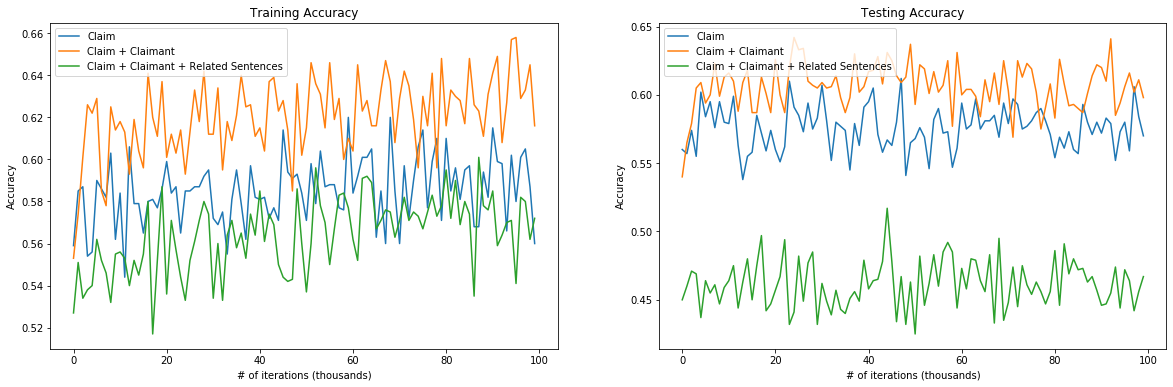

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)

plt.plot(rnn_i_train_acc)
plt.plot(rnn_ii_train_acc)
plt.plot(rnn_iii_train_acc)

plt.xlabel('# of iterations (thousands)')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.legend(['Claim', 'Claim + Claimant', 'Claim + Claimant + Related Sentences'], loc='upper left')

plt.subplot(1,2,2)

plt.plot(rnn_i_test_acc)
plt.plot(rnn_ii_test_acc)
plt.plot(rnn_iii_test_acc)

plt.xlabel('# of iterations (thousands)')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')

plt.legend(['Claim', 'Claim + Claimant', 'Claim + Claimant + Related Sentences'], loc='upper left')

plt.show()

# Discussion

Model iii that was trained on the claim concatenated with the claimant and 5 related sentences performed the worst on the training and test set. 

The RNN architecture with linear units is prone to the vanishing gradients problem. Since the documents with the 5 related sentences concatenated is much longer, it is tough for the neural network to backpropagate the error to earlier time steps of the network (especially where it was processing the claim itself, arguably an important feature). Long range dependencies are tough to capture in our vanilla architecture.

The network is prone to forgetting the earlier hidden state, especially from the claim itself since it was embedded into the hidden state first. A recency effect takes place. The entire hidden state is also a fixed size vector, so it is tough for longer documents that have the 5 sentences concatenated at the end to preserve enough meaningful information.

Model ii that used the claim and the claimant concatenated performed best on the training and test set. The second best performer was model i that used only the claim itself. This shows that the shorter document size enabled the network to preserve meaningful features in the embedding. It was also able to pick up the claimant as an important feature that it used to discriminate between sources and boost the accuracy.